In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:

from woundSegmentation.models.unets import Unet2D
from woundSegmentation.models.deeplab import Deeplabv3
from woundSegmentation.models.FCN import VGG_19
from woundSegmentation.models.SegNet import SegNet

from woundSegmentation.utils.learning.metrics import dice_coef, precision, recall
from woundSegmentation.utils.learning.losses import dice_coef_loss
from woundSegmentation.utils.io.data import DataGen, save_history

from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import numpy as np
import tensorflow as tf
import tensorflow_model_optimization as tfmot

import os
import time

%load_ext tensorboard

In [3]:
# Insira o modelo desejado
modelName = "mobilenetv2"

# Se o modelo é podado ou não
prune = True

In [17]:
import os
# Seleção do caminho
if prune:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    
print("Numero de GPUs disponiveis: ", len(tf.config.list_physical_devices('GPU')))

Numero de GPUs disponiveis:  0


In [4]:
# Modelos disponiveis
models = ["fcn", "mobilenetv2", "segnet", "unet"]


# Seleção do caminho
if prune:
    dirPath = '../woundSegmentation/results_prune/'
else:
    dirPath = '../woundSegmentation/results/'

# Criacao de arquivos
isdir = os.path.isdir(dirPath)
if not isdir:
    os.mkdir(dirPath)
    for i in range(len(models)):
        os.mkdir(dirPath + models[i])
        os.mkdir(dirPath + models[i] + "/training_history/")
        os.mkdir(dirPath + models[i] + "/datapredict/")
        
modelDirPath = dirPath + modelName + "/"

In [6]:
# Variaveis e gerador de dados
input_dim_x = 224
input_dim_y = 224
n_filters = 32
dataset = 'Foot Ulcer Segmentation Challenge'
datasetpath = '../woundSegmentation/data/' + dataset
#dataset= 'Medetec_foot_ulcer_224'
data_gen = DataGen('../woundSegmentation/data/' + dataset + '/', split_ratio=0.2, x=input_dim_x, y=input_dim_y)

In [7]:
# Unet
if (modelName == "unet"):
    unet2d = Unet2D(n_filters=n_filters, input_dim_x=None, input_dim_y=None, num_channels=3)
    model, model_name = unet2d.get_unet_model_yuanqing()
    print("Modelo Unet Carregado!")

In [8]:
# SegNet
if (modelName == "segnet"):
    segNet = SegNet(n_filters=n_filters, input_dim_x=None, input_dim_y=None, num_channels=3)
    model, model_name = segNet.get_SegNet()
    print("Modelo Segnet Carregado!")

In [9]:
# MobilenetV2
if (modelName == "mobilenetv2"):
    model = Deeplabv3(input_shape=(input_dim_x, input_dim_y, 3), classes=1)
    model_name = 'MobilenetV2'
    print("Modelo MobilenetV2 Carregado!")

Modelo MobilenetV2 Carregado!


In [10]:
# FCN
if (modelName == "fcn"):
    model = VGG_19(input_shape=(input_dim_x, input_dim_y, 3))
    model_name = 'FCN'
    print("Modelo FCN Carregado!")

In [11]:
# Configuracoes de treinamento
batch_size = 2
epochs = 150
learning_rate = 1e-4
loss = 'binary_crossentropy'

In [12]:
# Tecnica de poda
if prune:
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    
    num_images = 810 * (1 - 0.2)
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
    
    pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.1, final_sparsity=0.90, begin_step=0, end_step=end_step)
    }

    model_pruned = prune_low_magnitude(model, **pruning_params)
else:
  print('Não será Podado!')    

In [13]:
# Cria o txt do resumo do modelo
def printmodelsummary(s):
    with open(modelDirPath + modelName + 'Modelsummary.txt','a') as f:
        print(s, file=f)

model_pruned.summary(print_fn=printmodelsummary)

In [14]:
# callback
if prune:
    callbacks = [
        EarlyStopping(monitor='val_dice_coef', patience=50, mode='max', restore_best_weights=True),
        tfmot.sparsity.keras.UpdatePruningStep()
    ]
else:
    callbacks = [
        EarlyStopping(monitor='val_dice_coef', patience=50, mode='max', restore_best_weights=True)
    ]

In [28]:
# Treinamento
start = time.time()
model_pruned.compile(optimizer=Adam(lr=learning_rate), loss=loss, metrics=[dice_coef, precision, recall])
training_history = model_pruned.fit_generator(data_gen.generate_data(batch_size=batch_size, train=True),
                                       steps_per_epoch=int(data_gen.get_num_data_points(train=True) / batch_size),
                                       callbacks=callbacks,
                                       validation_data=data_gen.generate_data(batch_size=batch_size, val=True),
                                       validation_steps=int(data_gen.get_num_data_points(val=True) / batch_size),
                                       epochs=epochs)
end = time.time()
file = open(modelDirPath + modelName +"Time.txt", "w")
file.write("Treinamento\n")
file.write(str(end-start))
file.close()

Epoch 1/150


C:\Users\lucas\AppData\Local\Temp\ipykernel_23840\1338192546.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training_history = model_pruned.fit_generator(data_gen.generate_data(batch_size=batch_size, train=True),


324/324 [==============================] - 162s 402ms/step - loss: 0.2512 - dice_coef: 0.0028 - precision: 0.0059 - recall: 0.0128 - val_loss: 0.2022 - val_dice_coef: 1.7122e-08 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/150
324/324 [==============================] - 128s 394ms/step - loss: 0.1980 - dice_coef: 0.0057 - precision: 0.0148 - recall: 0.0025 - val_loss: 0.2021 - val_dice_coef: 1.7153e-08 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/150
324/324 [==============================] - 129s 398ms/step - loss: 0.1977 - dice_coef: 0.0031 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2018 - val_dice_coef: 1.7148e-08 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/150
324/324 [==============================] - 127s 393ms/step - loss: 0.1971 - dice_coef: 0.0048 - precision: 0.0039 - recall: 0.0013 - val_loss: 0.2022 - val_dice_coef: 1.7153e-08 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/150
324/324 [===========

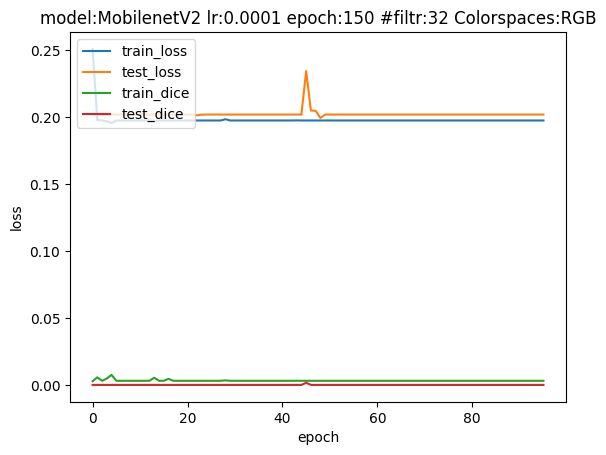

<Figure size 640x480 with 0 Axes>

In [29]:
# Salva o modelo e o historico de treinamento
save_history(model, model_name, training_history, dataset, n_filters, epochs, learning_rate, loss, color_space='RGB',
             path= modelDirPath + "training_history/", name= modelName + "prunedmodelfile")